In [1]:
%matplotlib inline
import os
import os.path
import csv
import numpy
import scipy.stats
import scipy.cluster
import itertools
import math
import sys
import sklearn.cluster
import sklearn.decomposition
import sklearn.manifold
import skimage.filters
import pandas
from matplotlib import pylab, mlab
import matplotlib.cm
import matplotlib.patches
import IPython.display
# local modules (in same dir as this notebook)
import plotutils
import datautils
import syspathutils


In [2]:
base_path = os.path.realpath(os.path.join(os.path.curdir, '..'))
data_path = os.path.join(base_path, 'samples')
syspathutils.append_to_sys_path('/home/gio/langdev/gitclones/arbimon2-jobs/.env/lib/python2.7/site-packages/')
syspathutils.append_to_sys_path('/home/gio/langdev/gitclones/arbimon2-jobs/lib/')

In [3]:
import a2audio.rec
import a2pyutils.storage
import a2audio.segmentation
import a2pyutils.convert

/usr/local/lib/python2.7/dist-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [4]:
datasets = {x.replace('sample', '').strip('_'):os.path.join(data_path, x) for x in (os.listdir(data_path) + ['sabana_seca/aoi1_rois_old/tmp'])}
print '\n'.join("{} : {}".format(x, y) for x, y in datasets.items())

sabana_seca : /home/gio/langdev/gitclones/mine/fltr-audio-seg/samples/sabana_seca
el_verde : /home/gio/langdev/gitclones/mine/fltr-audio-seg/samples/el_verde
validation_data : /home/gio/langdev/gitclones/mine/fltr-audio-seg/samples/validation_data
amarakaeri : /home/gio/langdev/gitclones/mine/fltr-audio-seg/samples/amarakaeri
sabana_seca/aoi1_rois_old/tmp : /home/gio/langdev/gitclones/mine/fltr-audio-seg/samples/sabana_seca/aoi1_rois_old/tmp


In [6]:
# dataset = 'sabana_seca/aoi1_rois_old/tmp'
# dataset = 'amarakaeri'
# dataset = 'el_verde'
dataset = 'sabana_seca'
# roi_filepath = ('/home/gio/langdev/gitclones/arbimon2-jobs/synth_output/rois.txt')

roi_filepath = os.path.join(datasets[dataset], 'rois.txt')

rois_data_ori = pandas.read_csv(roi_filepath)
# compute tod and site name from recording filename
rois_data_ori['tod'] = rois_data_ori['rec'].apply(lambda x: int(x.split('.')[0].split('_')[-1].split('-')[0]) if 'undefined' not in x else 0)
# rois_data_ori['site'] = rois_data_ori['rec'].apply(lambda x: int(x.split('/')[0]) if 'undefined' not in x else 0)
rois_data_ori['site'] = rois_data_ori['rec'].apply(lambda x: 1)

print "dataset:{}, sites:{}, recs:{}, rois:{}, rois per rec:{}".format(
    dataset,
    len(rois_data_ori.groupby('site')), 
    len(rois_data_ori.groupby('rec')), 
    len(rois_data_ori), 
    len(rois_data_ori) * 1.0 / len(rois_data_ori.groupby('rec'))
)

dataset:sabana_seca, sites:1, recs:240, rois:59058, rois per rec:246.075


In [7]:
rois_data_recs = pandas.DataFrame(rois_data_ori.groupby(['tod', 'rec']).groups.keys(), columns=['tod', 'rec'])
[[k, len(v)] for k,v in rois_data_recs.groupby('tod').groups.items()]

[[0, 9],
 [1, 10],
 [2, 10],
 [3, 10],
 [4, 10],
 [5, 10],
 [6, 10],
 [7, 10],
 [8, 10],
 [9, 10],
 [10, 10],
 [11, 10],
 [12, 10],
 [13, 10],
 [14, 10],
 [15, 10],
 [16, 10],
 [17, 10],
 [18, 10],
 [19, 11],
 [20, 10],
 [21, 10],
 [22, 10],
 [23, 10]]

In [8]:
print "\n".join(sorted(sample_by_tod))

NameError: name 'sample_by_tod' is not defined

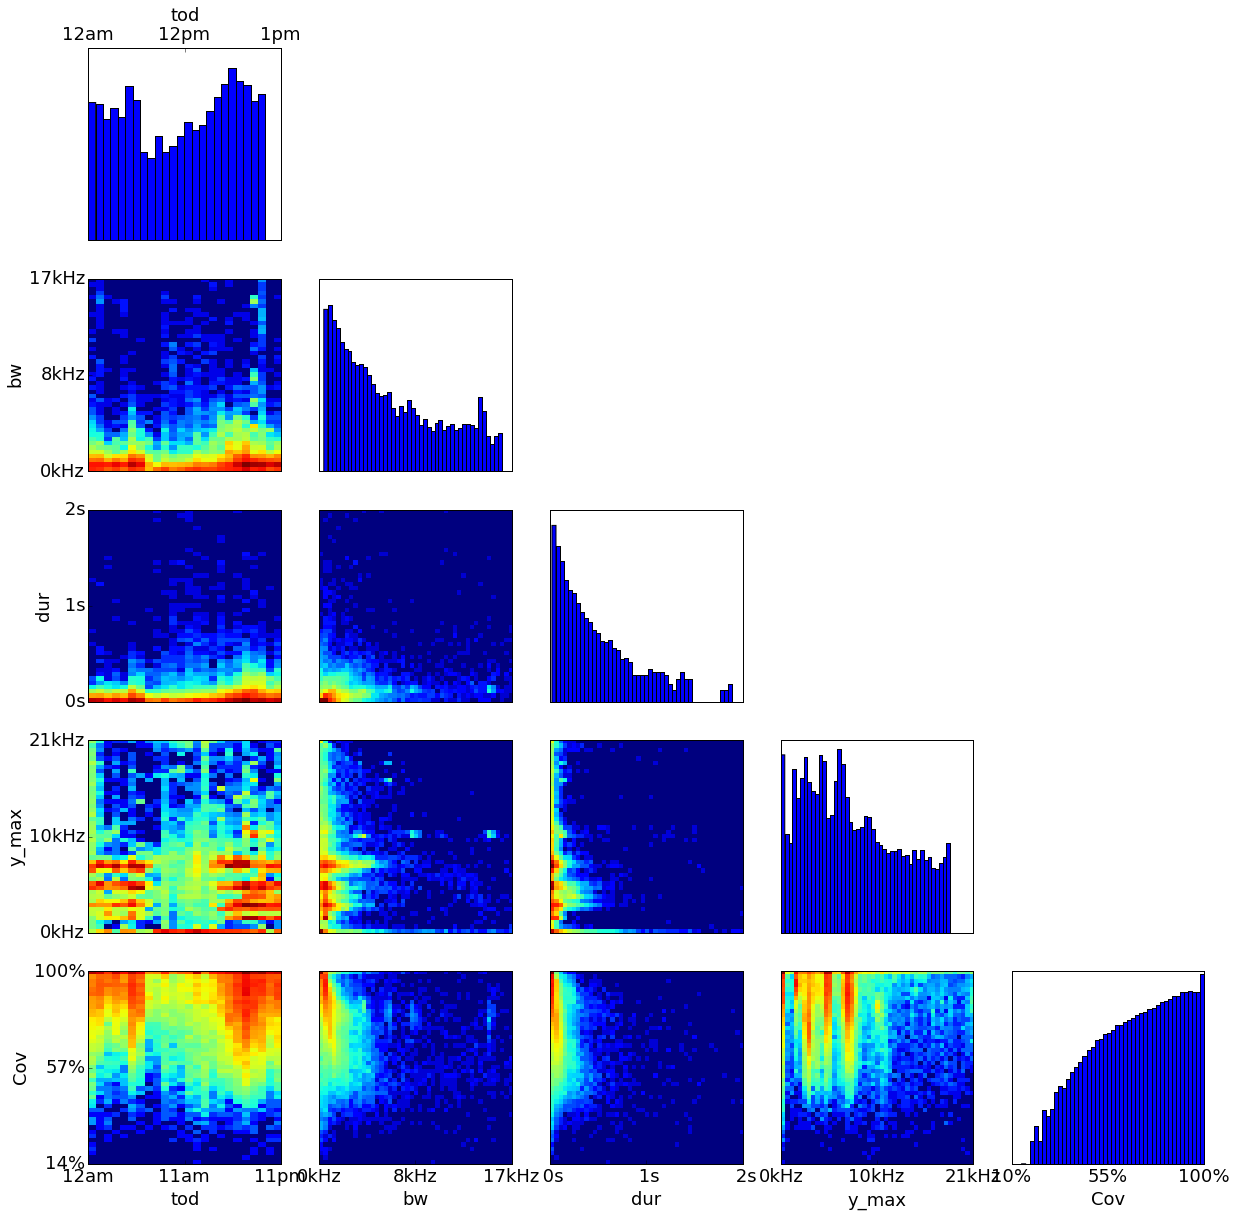

In [14]:
# recs_added = filter(lambda x: '.flac' == x[-5:], os.listdir(datasets[dataset]))
# sample_by_tod = reduce(
#     lambda a, b: a + b, 
#     map(
#         lambda _: 
#             rois_data_ori[(rois_data_ori.tod == _[0]) & ~rois_data_ori.rec.isin(recs_added)].sample(_[1]).rec.tolist(),
#         [[k, len(v)-10] for k,v in rois_data_recs.groupby('tod').groups.items() if len(v) > 10]
#     )
# )

# print "\n".join(sample_by_tod)
# rois_data_ori__removed = rois_data_ori[~rois_data_ori.rec.isin(sample_by_tod)]

stat_names = (
    'tod',
    'bw', 
    'dur', 
    'y_max', 
    'Cov',
)

# rois_data = rois_data_ori__removed
rois_data = rois_data_ori
rois_data = rois_data[list(stat_names)]
rois_data_names = tuple(stat_names)

H_bins = [24, 100, 100, 100, 100]
H, Hr = plotutils.sparse_histogramdd(rois_data, bins=H_bins)

def filter_H(H, approx_count):
    rng = numpy.arange(0, 7, .5)
    rng = (1 - (rng-numpy.floor(rng))) * (10)**numpy.ceil(rng)
    F = numpy.array([(i, len({h:H[h] for h in H if H[h] > i})) for i in rng])
    x = numpy.argmin(numpy.log(F[:,1] / approx_count)**2)
    return x, F[x,:]

H_count_filter, H_count_filter_C = filter_H(H, 10)

H_plot_bins = H_bins
pylab.figure(figsize=(20,20))
pylab.locator_params(nbins=4, tight=True)
plotutils.scatterplot_matrix(
    rois_data.as_matrix(), 
    stat_names, 
    log=True, bins=[24] + [45]*4, 
    hist_log=True,
    mtype="DD",
#     interpolation="nearest", 
    
    tick_count = 3,
    tick_fmt = [
        TickFormat.am_pm,
        TickFormat.kHz,
        TickFormat.sec,
        TickFormat.kHz,
        TickFormat.percent
    ],
    interpolation="nearest",
#     plotter = plotutils.density_contour_plot,
    plotter = plotutils.density_plot,
#     hist_plotter = plotutils.violin_contour_plot
)

In [98]:
rois_data_ori__removed = rois_data_ori[~rois_data_ori.rec.isin(sample_by_tod)]

In [15]:
stat_names = (
    'tod',
#     'site',
#     'x', 'y', 'Sxx', 'Syy', 'Sxy', 
    'bw', 
    'dur', 
#     'muy', 'mux', 
#     'y', 'muy',
    'y_max', 
#     'x_max',
    'Cov',
#     '1a_Sxx', '1a_Syy', '1a_Sxy', '1b_Sxx', '1b_Syy', '1b_Sxy', 
#     '1c_Sxx', '1c_Syy', '1c_Sxy', '1d_Sxx', '1d_Syy', '1d_Sxy'
)

rois_data = rois_data_ori
# rois_data = rois_data_ori[rois_data_ori['site'] == 772]
rois_data = rois_data[list(stat_names)]
rois_data_names = tuple(stat_names)

# H_bins = [10, 24,100,100,100,100,100]
H_bins = [24, 100, 100, 100, 100]

H, Hr = plotutils.sparse_histogramdd(rois_data, bins=H_bins)
print "rois:{}, histogram bins:{}, reduction:{}%".format(len(rois_data), len(H), len(H) * 1.0 / len(rois_data))

def filter_H(H, approx_count):
    rng = numpy.arange(0, 7, .5)
    rng = (1 - (rng-numpy.floor(rng))) * (10)**numpy.ceil(rng)
    F = numpy.array([(i, len({h:H[h] for h in H if H[h] > i})) for i in rng])
    x = numpy.argmin(numpy.log(F[:,1] / approx_count)**2)
    return x, F[x,:]

H_count_filter, H_count_filter_C = filter_H(H, 10)


print H_count_filter, H_count_filter_C


rois:59058, histogram bins:42867, reduction:0.725845778726%
3 [ 50.   8.]


In [16]:
matplotlib.rcParams['font.size'] = 18

# Some methods for formatting the plot ticks
class TickFormat:
    @staticmethod
    def am_pm(x):
        x=int(x)
        return "{}{}".format(x%12 or 12, "pm" if x > 11 else "am")

    @staticmethod
    def kHz(x, prec=1):
        return "{}kHz".format(int(x/(1000*prec))*prec)

    @staticmethod
    def kHz_1(x):
        return TickFormat.kHz(x, .1)
    
    sec = "%2ds"

    @staticmethod
    def percent(x):
        return "{}%".format(int(float(x)*100))
    
def show_plot(var1, var2, fmt1, fmt2, b1, b2, X=None):
    if X is None:
        X = rois_data
    pylab.figure(figsize=(10,10))
    plotutils.density_plot(X[var1], X[var2], bins=[b2, b1], interpolation="nearest", log=True)
    plotutils.set_plot_axis(pylab.gca(), 'x', visible=True, label=var1)
    plotutils.set_plot_axis(pylab.gca(), 'y', visible=True, label=var2)
    plotutils.set_tick_labels(pylab.gca(), 'x', fmt1 if callable(fmt1) else getattr(TickFormat, fmt1))
    plotutils.set_tick_labels(pylab.gca(), 'y', fmt2 if callable(fmt2) else getattr(TickFormat, fmt2))

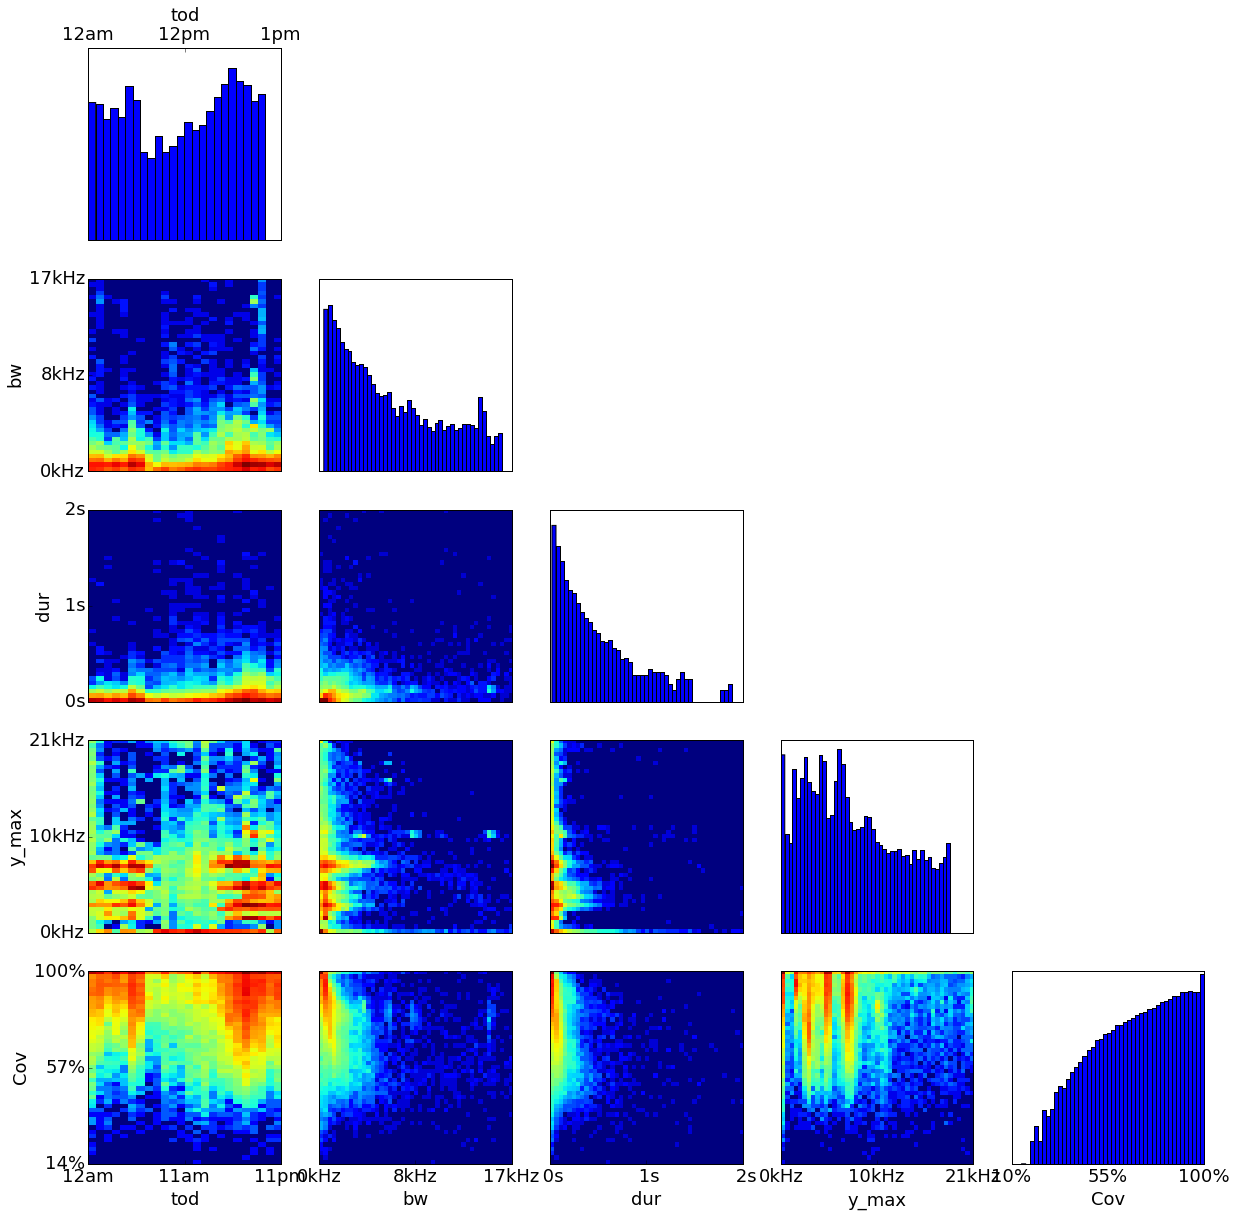

In [17]:
reload(plotutils)
H_plot_bins = H_bins
pylab.figure(figsize=(20,20))
pylab.locator_params(nbins=4, tight=True)
plotutils.scatterplot_matrix(
    rois_data.as_matrix(), 
    stat_names, 
    log=True, bins=[24] + [45]*4, 
    hist_log=True,
    mtype="DD",
#     interpolation="nearest", 
    
    tick_count = 3,
    tick_fmt = [
        TickFormat.am_pm,
        TickFormat.kHz,
        TickFormat.sec,
        TickFormat.kHz,
        TickFormat.percent
    ],
    interpolation="nearest",
#     plotter = plotutils.density_contour_plot,
    plotter = plotutils.density_plot,
#     hist_plotter = plotutils.violin_contour_plot
)

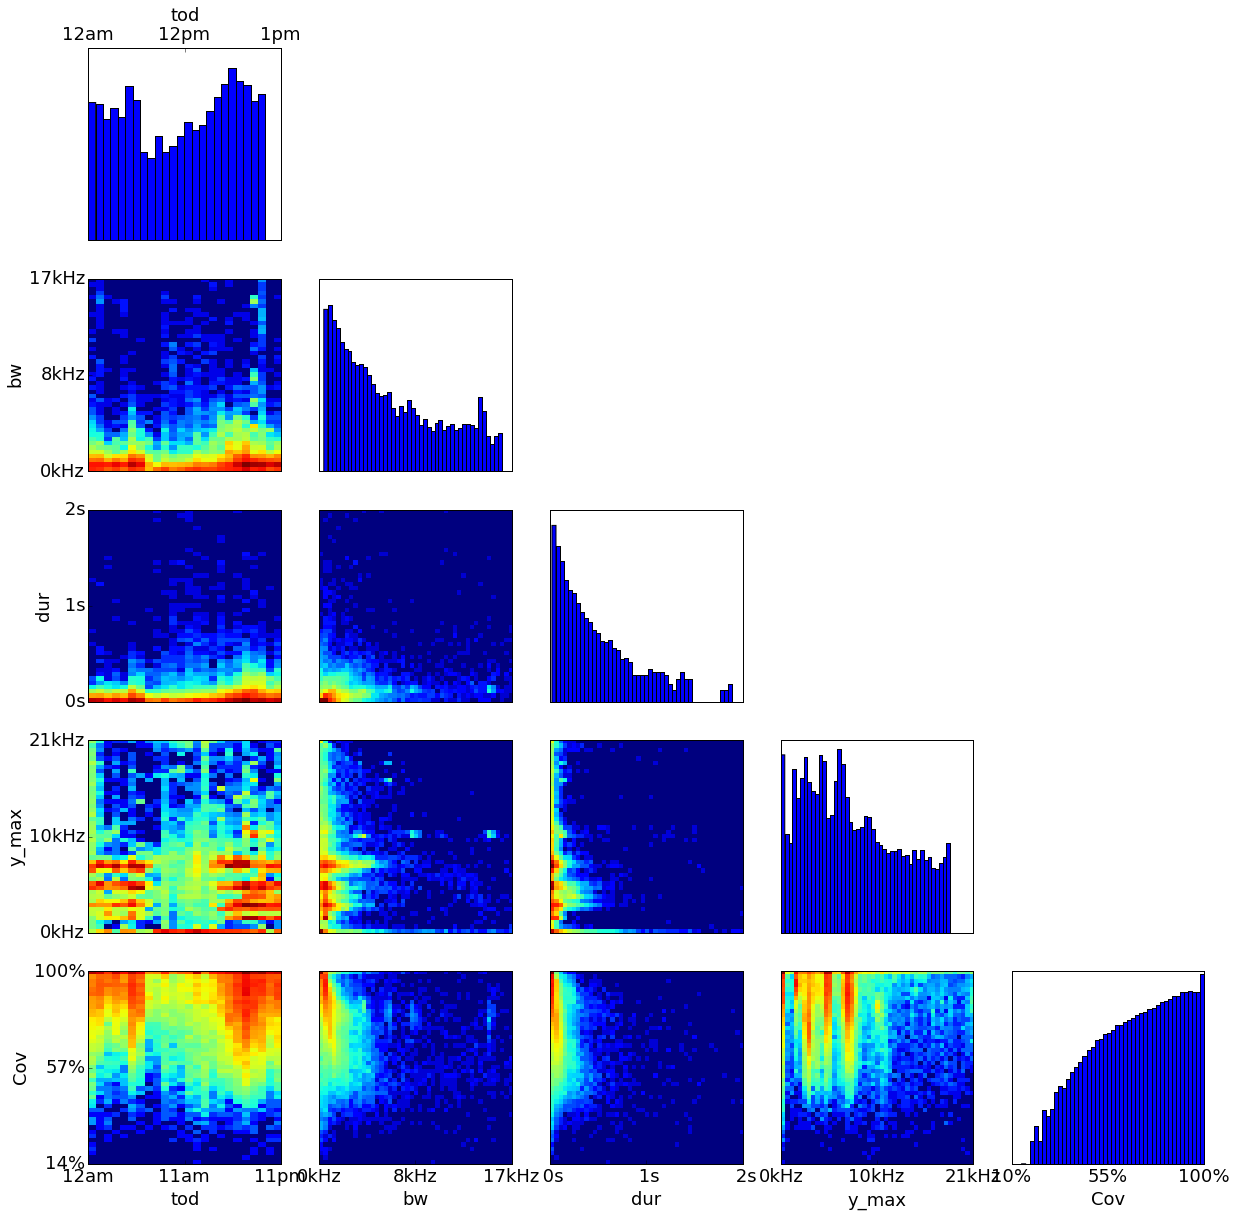

In [18]:
reload(plotutils)
H_plot_bins = H_bins
pylab.figure(figsize=(20,20))
pylab.locator_params(nbins=4, tight=True)
plotutils.scatterplot_matrix(
    rois_data.as_matrix(), 
    stat_names, 
    log=True, bins=[24] + [45]*4, 
    hist_log=True,
    mtype="DD",
#     interpolation="nearest", 
    
    tick_count = 3,
    tick_fmt = [
        TickFormat.am_pm,
        TickFormat.kHz,
        TickFormat.sec,
        TickFormat.kHz,
        TickFormat.percent
    ],
    interpolation="nearest",
#     plotter = plotutils.density_contour_plot,
    plotter = plotutils.density_plot,
#     hist_plotter = plotutils.violin_contour_plot
)

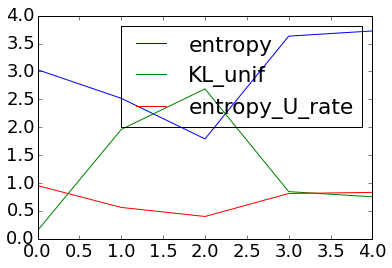

In [19]:
def entropy(X, bins):
    P = numpy.histogram(X, bins=bins)[0]
    return scipy.stats.entropy(P)
def KL_unif(X, bins):
    P = numpy.histogram(X, bins=bins)[0]
    return scipy.stats.entropy(P, [len(X) * 1.0 / len(P)] * len(P))
def entropy_U_rate(X, bins):
    P = numpy.histogram(X, bins=bins)[0]
    return scipy.stats.entropy(P) / numpy.log(len(P))

# map(scipy.stats.entropy, map(lambda x,y: numpy.histogram(rois_data[x], bins=y)[1], rois_data.columns, [24,88,88,88,88]))
for F in [entropy, KL_unif, entropy_U_rate]:
    pylab.plot(map(lambda x,y: F(rois_data[x], y), rois_data.columns, [24,88,88,88,88]),label=F.__name__)
pylab.legend()


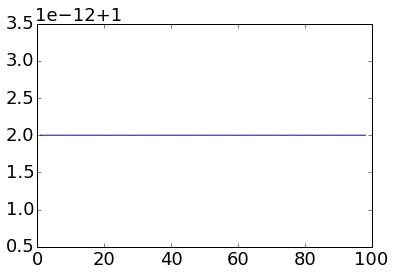

In [55]:
pylab.plot([scipy.stats.entropy([i**2*1.0]*i)/numpy.log(i) for i in range(1,100)])

In [ ]:
import matplotlib.ticker as ticker
reload(plotutils)

print plotutils.__file__
pylab.figure(figsize=(20,20))
plotutils.violin_contour_plot(rois_data['y_max'], bins=88, log=10, cmap=matplotlib.cm.jet)
pylab.title("log10(y_max) violin plot " + dataset)
pylab.colorbar()
pylab.gca().xaxis.set_minor_locator(ticker.MultipleLocator(200))
pylab.gca().xaxis.set_major_locator(ticker.MultipleLocator(1000))
# pylab.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))
# pylab.gca().xaxis.set_major_locator(ticker.MultipleLocator(3))
pylab.grid(b=True, which='minor', color='white',linestyle='--')
pylab.grid(b=True, which='major', color='black',linestyle='-')
# pylab.gca().set_xlim(1000, 5000)

In [ ]:
dataset_path = datasets[dataset]
areas_of_interest = pandas.read_csv(os.path.join(dataset_path, 'areas_of_interest.txt'))

for i, aoi in areas_of_interest.iterrows():
    print "subregion:: {} <= bw <= {}, {} <= y_max <= {}".format(aoi.bw_min, aoi.bw_max, aoi.y_max_min, aoi.y_max_max)


show_plot('tod','y_max', 'am_pm', 'kHz', 24, 45)
show_plot('bw','y_max', 'kHz', 'kHz', 45, 45)

show_plot('bw', 'y_max', 'kHz', 'kHz', 45, 45)
edgecolor="black"
for i, aoi in areas_of_interest.iterrows():
    xy = (aoi.bw_min, aoi.y_max_min)
    w, h = aoi.bw_max - aoi.bw_min, aoi.y_max_max - aoi.y_max_min
    pylab.gca().add_patch(matplotlib.patches.Rectangle(xy, w, h, edgecolor=edgecolor, facecolor='none', linewidth=5))

for i, aoi in areas_of_interest.iterrows():
    xy = (aoi.bw_min, aoi.y_max_min)
    w, h = aoi.bw_max - aoi.bw_min, aoi.y_max_max - aoi.y_max_min
    br = max(w, h) * 3
    limx0, limx1 = max(aoi.bw_min-br, rois_data['bw'].min()), min(aoi.bw_max+br, rois_data['bw'].max())
    limy0, limy1 = max(aoi.y_max_min-br, rois_data['y_max'].min()), min(aoi.y_max_max+br, rois_data['y_max'].max())
    pylab.figure(figsize=(10,10))
    show_plot('bw', 'y_max', TickFormat.kHz_1, TickFormat.kHz_1, 45, 45)
    pylab.gca().set_xlim(limx0, limx1)
    pylab.gca().set_ylim(limy0, limy1)
    pylab.gca().add_patch(matplotlib.patches.Rectangle(xy, w, h, edgecolor=edgecolor, facecolor='none', linewidth=5))


In [ ]:
rois_subdata_sample_bounds = pandas.read_csv(os.path.join(dataset_path, 'aoi2_sampled_rois.txt'), index_col=0)
rois_subdata_sample_full = rois_data_ori.loc[rois_subdata_sample_bounds.index]
print "entries:{}, cols:{}".format(len(rois_subdata_sample_full), list(rois_subdata_sample_full.columns))

In [ ]:
sabana_seca1_sample_storage = a2pyutils.storage.from_uri(dataset_path)
# region_rois_output = a2pyutils.storage.from_uri(os.path.join(dataset_path, 'aoi1_rois')

idxx = [0]
pylab.figure(figsize=(21,21))
for i, (idx, roi_row) in enumerate(rois_subdata_sample_full.iloc[idxx].iterrows()):
# for i, (idx, roi_row) in enumerate(rois_subdata_sample_full.iterrows()):
    print "{} of {}   idx:{} rec:{}".format(i, len(rois_subdata_sample_full), idx, roi_row['rec'])
    roi_rec = a2audio.rec.Rec(roi_row['rec'], '', sabana_seca1_sample_storage)
    spectrum, freqs, times = roi_rec.getSpectrogram()
    specDB = a2pyutils.convert.power2decibels(spectrum)
    max_v = specDB.flatten().max()
    duration = roi_rec.samples * 1.0 / roi_rec.sample_rate
    max_freq = roi_rec.sample_rate / 2.0
    px2sec = duration / specDB.shape[1]
    px2Hz = max_freq / specDB.shape[0]
    
    x0, y1 = roi_row['x'], specDB.shape[0] - roi_row['y']
    x1, y0 = x0 + roi_row['w'], y1 - roi_row['h']
    
    t0, t1 = x0 * px2sec, x1 * px2sec
    f0, f1 = y0 * px2Hz, y1 * px2Hz
    
    pad=10
    roi = datautils.clip_pad_and_draw_rgb_bounds(specDB, x0, x1,y0, y1, pad, (.25,1.0,.25))
    
    pylab.subplot(math.ceil(2*len(idxx)*1.0/2),2,2*i)
    pylab.title("{}\n ({}-{} s)-({}-{}Hz)".format(roi_row['rec'],t0,t1,f0,f1))
    pylab.imshow(
         roi,
         interpolation="nearest",
         origin='lower'
    )


    pylab.subplot(math.ceil(2*len(idxx)*1.0/2),2,2*i+1)
    spec2samp = roi_rec.original.shape[0] * 1.0 / spectrum.shape[1]
    samp_x0, samp_x1 = int((x0-pad)*spec2samp), int((x1+pad)*spec2samp+.5)
    roi_clip = roi_rec.original[samp_x0:samp_x1]
    pylab.plot(numpy.log10(abs(roi_clip)) * numpy.sign(roi_clip))
    
#     with region_rois_output.open_for_writing("roi2-{}.png".format(i)) as fout:
#         pylab.imsave(fout, 
#              roi,
#              origin='lower'
#         )

In [ ]:
idx = 13

roi_row = rois_subdata_sample_full.iloc[idx]
roi_rec = a2audio.rec.Rec(roi_row['rec'], '', sabana_seca1_sample_storage)
spectrum, freqs, times = roi_rec.getSpectrogram()
specDB = a2pyutils.convert.power2decibels(spectrum)
max_v = specDB.flatten().max()
duration = roi_rec.samples * 1.0 / roi_rec.sample_rate
max_freq = roi_rec.sample_rate / 2.0
px2sec = duration / specDB.shape[1]
px2Hz = max_freq / specDB.shape[0]

x0, y1 = roi_row['x'], specDB.shape[0] - roi_row['y']
x1, y0 = x0 + roi_row['w'], y1 - roi_row['h']

t0, t1 = x0 * px2sec, x1 * px2sec
f0, f1 = y0 * px2Hz, y1 * px2Hz

spec2samp = roi_rec.original.shape[0] * 1.0 / spectrum.shape[1]
pad=10
samp_x0, samp_x1 = int((x0-pad)*spec2samp), int((x1+pad)*spec2samp+.5)

roi_clip = roi_rec.original[samp_x0:samp_x1]

# filter_schedule = [0,0,0,1,1,2,2,3,3,3,2,2,1,1,0,0,0]
filter_schedule = [0,0,0,1,1,2,2,3,4,5,5,5,4,3,2,2,1,1,0,0,0]

roi_clip_bpf = numpy.concatenate([datautils.butter_bandpass_filter(roi_rec.original, f0, f1, roi_rec.sample_rate, order=1, passes=i)[samp_x0:samp_x1] for i in filter_schedule])

pylab.figure(figsize=(15,5))
pylab.suptitle("ROI #{}".format(idx))
pylab.plot(roi_clip_bpf)
pylab.figure(figsize=(10,5))
pylab.subplot(1,2,2)
pylab.specgram(roi_clip, Fs=roi_rec.sample_rate)
# pylab.hlines(f0, 0, )
cb1=pylab.colorbar()
pylab.subplot(1,2,1)
pylab.specgram(roi_clip_bpf, Fs=roi_rec.sample_rate, vmin=cb1.vmin, vmax=cb1.vmax)

IPython.display.display(IPython.display.Audio(roi_clip_bpf, rate=roi_rec.sample_rate))